#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Sentiment Analysis`

#### Group:
- `Karolina Rączkowska #1`
- `Marek Rewoliński #2`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- EDA
- Sentiment Analysis - Transformers
- Sentiment Analysis - VADER
- Emotion Detection


In [177]:
# Enable autoreload for automatic module reloading
%load_ext autoreload
%autoreload 2

# Core libraries
import pandas as pd
import numpy as np
import re
import csv
import urllib.request

# Transformers for NLP tasks
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline

# Preprocessing utilities
import Preprocessing
from utils1 import pipeline_v1e
from nltk.tokenize import PunktSentenceTokenizer
# Uncomment the line below to download the Punkt tokenizer if needed
# nltk.download('punkt_tab')

# NLTK for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Uncomment the line below to download the VADER lexicon if needed
# nltk.download('vader_lexicon')

# TextBlob for sentiment analysis
from textblob import TextBlob
# Uncomment the line below to install TextBlob if needed
# %pip install textblob

# Metrics for regression and classification
from scipy.stats import pearsonr
from scipy.special import softmax
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    mean_squared_error, 
    mean_absolute_percentage_error
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Uncomment the line below to install WordCloud if needed
# %pip install wordcloud


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
restaurants_raw = pd.read_csv(r"data_hyderabad/105_restaurants.csv")
reviews_raw = pd.read_csv(r"data_hyderabad/10k_reviews.csv")

In [52]:
restaurants_raw.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [53]:
# find the ratings in reviews
example = """
smoked salmon Croissant 4.5/5
mushroom melt 4/5
Smoked salmon bagel 3.5/5
prawn croissant 4.5/5"""


example_ratings = reviews_raw.iloc[881]['Review']

rating_review_pattern = re.compile(r"([a-zA-Z\s]+)\s([\d\.]+\/\d)", re.IGNORECASE)
ratings = rating_review_pattern.findall(example_ratings)
print(ratings)



[('d rate food', '3/5'), ('\r\nAmbience', '4/5'), ('\r\nLocation', '4/5')]


In [54]:
# Apply the regex pattern to the "Review" column to extract ratings
reviews_raw['Extracted_Ratings'] = reviews_raw['Review'].apply(lambda x: rating_review_pattern.findall(x) if isinstance(x, str) else [])

# Display the DataFrame with the new column
reviews_raw[['Review', 'Extracted_Ratings']]
reviews_raw.sort_values(by='Extracted_Ratings', ascending=False)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Extracted_Ratings
543,The Fisherman's Wharf,Rajen_6packfoodie,#6packfoodie goes The Fisherman's Wharf!\r\n\r...,3,"55 Reviews , 682 Followers",4/21/2019 10:40,3,"[(why, 3/5)]"
3230,Marsala Food Company,Sudhir Raju,Starters were served cold...all they did was r...,1,"2 Reviews , 9 Followers",4/5/2019 14:16,0,[(we had buffet and some of the items were mis...
3366,Club Rogue,Pranay Agarwal,this place freakin crazy lil fuzzy over crowde...,4,"122 Reviews , 1206 Followers",2/15/2019 18:59,0,[(this place freakin crazy lil fuzzy over crow...
4054,Frio Bistro,Kalyan Ch,This place was on my list for a long time.\r\n...,1,"9 Reviews , 2 Followers",12/30/2018 20:19,0,"[(t serve a, 1/2)]"
5076,Gal Punjab Di,Mrutunjay Kinagi,Best paratha you can get in Hyderabad in Gachi...,5,"15 Reviews , 324 Followers",8/21/2018 21:06,0,"[(s little expensive but, 10/1)]"
...,...,...,...,...,...,...,...,...
3368,Club Rogue,Maria.cancer78,Hello...\r\nThe ambience is amazing..and the f...,4,1 Review,2/15/2019 15:39,0,[]
3369,Club Rogue,Aditya Reddy,Worst place in Hyderabad. Staff has no etiquet...,1,"5 Reviews , 1 Follower",2/13/2019 20:07,0,[]
3370,Club Rogue,Amlan Dutta,Ambiance is good. There is a dance floor with ...,2,"17 Reviews , 68 Followers",2/13/2019 9:40,0,[]
3371,Club Rogue,Vaishnavi,My friend gave his birthday treat here! We opt...,3,"21 Reviews , 51 Followers",2/11/2019 2:37,0,[]


```markdown
##EDA

In [55]:
reviews_ratings = reviews_raw.groupby('Rating').agg({'Review': 'count'})
reviews_ratings

,Review
Rating,
1,1735
1.5,9
2,684
2.5,19
3,1192
3.5,47
4,2373
4.5,69
5,3826


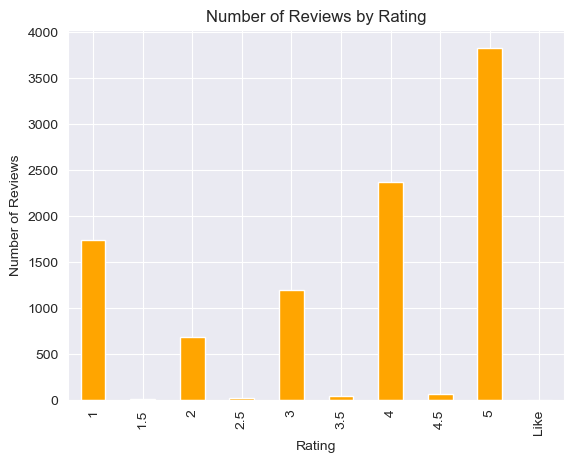

In [56]:
reviews_ratings.plot(kind='bar', legend=False, color = 'orange')
plt.title('Number of Reviews by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [57]:
non_integer_ratings = reviews_raw[reviews_raw['Rating'].apply(lambda x: '.' in str(x))]
non_integer_ratings

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Extracted_Ratings
975,Cream Stone,Yashwant Darsi,It's too crowded with delivery executives all ...,3.5,"14 Reviews , 83 Followers",11/13/2018 20:09,0,[]
1151,Barbeque Nation,The Foodie Bookworm,We are very satisfied with the food and the se...,4.5,"108 Reviews , 242 Followers",10/25/2018 7:57,0,[]
1188,Barbeque Nation,Deepak,Quick review points\r\n- slippery floor .. be ...,2.5,"2 Reviews , 3 Followers",6/23/2018 14:54,0,[]
2170,Jonathan's Kitchen - Holiday Inn Express & Suites,Devyani Agrawal,Amazing food. The way they serve it will make ...,4.5,"13 Reviews , 67 Followers",2/14/2019 23:23,0,[]
2831,Behrouz Biryani,Nikita.ved,Biryani is good but they didn't deliver ...I h...,2.5,"1 Review , 2 Followers",12/21/2018 13:19,0,[]
...,...,...,...,...,...,...,...,...
9987,Chinese Pavilion,Deba Das,Initially thought of going to Wonton (Gachibow...,3.5,"31 Reviews , 101 Followers",7/24/2016 16:44,3,"[(\r\nTASTE, 3.1/5), (\r\nSERVICE, 5/5), (\r\n..."
9994,Chinese Pavilion,Shiladitya Chaudhury,Chinese Pavilion in Banjara HIlls was the firs...,1.5,"6 Reviews , 3 Followers",6/5/2016 10:49,0,[]
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,[]
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,[]


In [58]:
ratings_restaurants = reviews_raw.groupby('Restaurant').agg({'Rating': 'value_counts'}).unstack(fill_value=0)
ratings_restaurants.loc['Total'] = ratings_restaurants.sum()
ratings_restaurants

Rating                                   \
Rating                                     1 1.5    2 2.5     3 3.5     4 4.5   
Restaurant                                                                      
10 Downing Street                          7   0    5   0    14   0    49   0   
13 Dhaba                                  22   0    7   0     8   0    27   0   
3B's - Buddies, Bar & Barbecue             2   0    4   0     1   0     2   0   
AB's - Absolute Barbecues                  0   0    2   0     1   0     4   0   
Absolute Sizzlers                         20   0    7   0     9   0    19   0   
...                                      ...  ..  ...  ..   ...  ..   ...  ..   
Yum Yum Tree - The Arabian Food Court     12   0   14   0    16   0    22   0   
Zega - Sheraton Hyderabad Hotel            1   0    2   0     8   0    29   0   
Zing's Northeast Kitchen                  13   0   10   0    13   0    27   0   
eat.fit                                   27   0    7   0    15   0    21   0   
Total                                   1735   9  684  19  1193  47  2373  69   

                                                  
Rating                                    5 Like  
Restaurant                                        
10 Downing Street                        25    0  
13 Dhaba                                 36    0  
3B's - Buddies, Bar & Barbecue           91    0  
AB's - Absolute Barbecues                93    0  
Absolute Sizzlers                        45    0  
...                                     ...  ...  
Yum Yum Tree - The Arabian Food Court    36    0  
Zega - Sheraton Hyderabad Hotel          60    0  
Zing's Northeast Kitchen                 37    0  
eat.fit                                  30    0  
Total                                  3832    1  

[101 rows x 10 columns]

```markdown
### Sentiment Analysis - Transformers


In [59]:
reviews_data = reviews_raw[reviews_raw["Rating"].notna() & reviews_raw["Review"].notna()]
reviews_data.isna().sum()

Restaurant           0
Reviewer             0
Review               0
Rating               0
Metadata             0
Time                 0
Pictures             0
Extracted_Ratings    0
dtype: int64

In [60]:
reviews_data.drop(reviews_data[reviews_data['Rating']=='Like'].index, inplace=True)

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\3204747852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data.drop(reviews_data[reviews_data['Rating']=='Like'].index, inplace=True)


In [61]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Restaurant         9954 non-null   object
 1   Reviewer           9954 non-null   object
 2   Review             9954 non-null   object
 3   Rating             9954 non-null   object
 4   Metadata           9954 non-null   object
 5   Time               9954 non-null   object
 6   Pictures           9954 non-null   int64 
 7   Extracted_Ratings  9954 non-null   object
dtypes: int64(1), object(7)
memory usage: 699.9+ KB


In [62]:
reviews_data['Review'] = reviews_data['Review'].astype(str)
reviews_data['Rating'] = reviews_data['Rating'].astype(float)

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\1440895010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Review'] = reviews_data['Review'].astype(str)
C:\Users\karom\AppData\Local\Temp\ipykernel_19752\1440895010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Rating'] = reviews_data['Rating'].astype(float)


In [63]:
reviews_data['Preprocessed_Review'] = reviews_data['Review'].apply(lambda x: Preprocessing.main_pipeline(
    x,no_hashtags=False,
    no_newlines=True,
    no_urls=True,
    no_punctuation=False,
    print_output=False, 
    lowercase=False, 
    lemmatized=False,
    stemmed=False))

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\2110358284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Preprocessed_Review'] = reviews_data['Review'].apply(lambda x: Preprocessing.main_pipeline(


In [64]:
reviews_preproc = reviews_data.copy()

In [69]:
##isue with review 96, 2066,6335 same problem

reviews_preproc.iloc[96]

Restaurant                                               Beyond Flavours
Reviewer                                                    Kailash Sain
Review                 I really enjoyed the follows....\r\nThe entran...
Rating                                                               5.0
Metadata                                                        1 Review
Time                                                      5/3/2019 20:10
Pictures                                                               0
Extracted_Ratings                                                     []
Preprocessed_Review    I really enjoyed the The entrance, the music, ...
Name: 96, dtype: object

In [70]:
model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model)
sentiment_tokenizer = AutoTokenizer.from_pretrained(model)
#optimus_primer = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
sentiment_task = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer, max_length=510,truncation=True)

In [72]:
reviews_sentiment_label = reviews_preproc.copy()

In [73]:
from tqdm import tqdm

sentiments = []
for review in tqdm(reviews_sentiment_label['Preprocessed_Review'], desc="Processing reviews"):
    try:
        sentiment = sentiment_task(review, max_length=510, truncation=True)
        sentiments.append(sentiment[0])
    except RuntimeError as e:
        print(f"RuntimeError for review: {review}\nError: {e}")
        sentiments.append({'label': 'error', 'score': 0.0})

reviews_sentiment_label['Sentiment_Label'] = [sentiment['label'] for sentiment in sentiments]
reviews_sentiment_label['Sentiment_Score'] = [sentiment['score'] for sentiment in sentiments]

Processing reviews:   0%|          | 0/9954 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [74]:
reviews_sentiment_label = pd.read_csv('reviews_sentiment_label.csv')

In [75]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   object 
 9   Sentiment_Score      9954 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 777.8+ KB


In [76]:
reviews_sentiment_label['Sentiment_Label'] = reviews_sentiment_label['Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [77]:
reviews_sentiment_label.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803


In [78]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [79]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   int64  
 9   Sentiment_Score      9954 non-null   float64
 10  Rating_label         9954 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 855.5+ KB


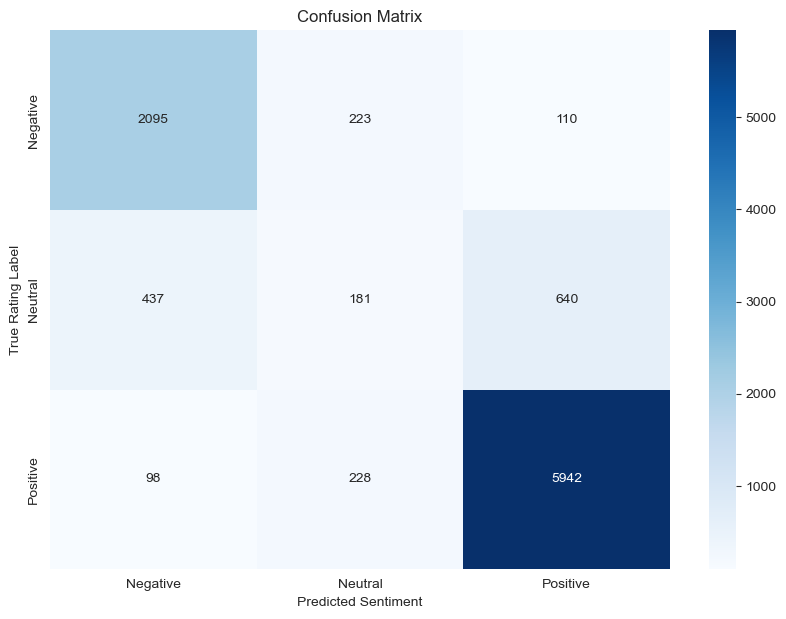

In [80]:
# Create the confusion matrix
conf_matrix = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Sentiment_Label'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix')
plt.show()

In [81]:
accuracy = (conf_matrix.trace()) / conf_matrix.sum()
accuracy

0.8255977496483825

In [82]:
true_labels = reviews_sentiment_label['Rating_label']
predicted_labels = reviews_sentiment_label['Sentiment_Label']

report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83      2428
     Neutral       0.29      0.14      0.19      1258
    Positive       0.89      0.95      0.92      6268

    accuracy                           0.83      9954
   macro avg       0.66      0.65      0.65      9954
weighted avg       0.79      0.83      0.80      9954


MOST FREQUENT WORDS ANALYSIS BY SENTIMENT

In [83]:
reviews_sentiment_label.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score,Rating_label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,2
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,2
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,2
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,2
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,2


In [84]:
reviews_sentiment_label['Preprocessed_review2'] = reviews_sentiment_label['Review'].apply(lambda content:\
    Preprocessing.main_pipeline(str(content), 
                                no_hashtags=True,
                                no_newlines=True, 
                                no_urls=True, 
                                no_punctuation=True, 
                                lowercase=True, 
                                lemmatized=True, 
                                stemmed=False, 
                                print_output=False,
                                no_stopwords=True,
                                ))
    

In [85]:
reviews_sentiment_label.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score,Rating_label,Preprocessed_review2
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,2,ambience wa good food wa quite good saturday l...
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,2,ambience good pleasant even service prompt foo...
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,2,must try great food great ambience thnx servic...
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,2,soumen da arun wa great guy behavior sincerety...
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,2,food good order kodi drumstick basket mutton b...


In [86]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")

In [87]:
positive_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 2]
neutral_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 1]
negative_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 0]

In [88]:
reviews_all = [positive_reviews, neutral_reviews, negative_reviews]

In [89]:
# Initialize lists to store bow_matrix and bow_features
bow_matrices = []
bow_features_list = []

for reviews in reviews_all:
    bow_matrix = bow_vectorizer.fit_transform(reviews['Preprocessed_review2']).toarray()
    reviews['bow_matrix'] = bow_matrix.tolist()
    bow_features = bow_vectorizer.get_feature_names_out()
    
    # Store the bow_matrix and bow_features
    bow_matrices.append(bow_matrix)
    bow_features_list.append(bow_features)

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\2354419002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['bow_matrix'] = bow_matrix.tolist()
C:\Users\karom\AppData\Local\Temp\ipykernel_19752\2354419002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['bow_matrix'] = bow_matrix.tolist()
C:\Users\karom\AppData\Local\Temp\ipykernel_19752\2354419002.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [90]:
def word_freq(bow_matrices, bow_features_list, idx,):
    word_counts = np.sum(bow_matrices[idx], axis=0)
    word_freq = pd.DataFrame({'words': bow_features_list[idx], 'frequency': word_counts})
    word_freq = word_freq.sort_values(by='frequency', ascending=False)
    return dict(zip(bow_features_list,word_counts))

In [91]:
def plot_term_frequency(df,nr_terms):
    
    plt.figure(figsize=(10, 8))
    sns_plot = sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    plt.title(f"Top {nr_terms} Words")
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()


In [92]:
# Function to calculate word frequency
def word_freq(bow_matrices, bow_features_list, idx):
    word_counts = np.sum(bow_matrices[idx], axis=0)
    word_freq = pd.DataFrame({'words': bow_features_list[idx], 'frequency': word_counts})
    word_freq = word_freq.sort_values(by='frequency', ascending=False)
    return word_freq

# Function to plot term frequency
def plot_term_frequency(df, nr_terms, type):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    plt.title(f"Top {nr_terms} words in {type} reviews")
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Function to generate and display a word cloud
def plot_wordcloud(word_freq_df, type):
    word_freq_dict = dict(zip(word_freq_df['words'], word_freq_df['frequency']))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word cloud of {type} reviews")
    plt.show()


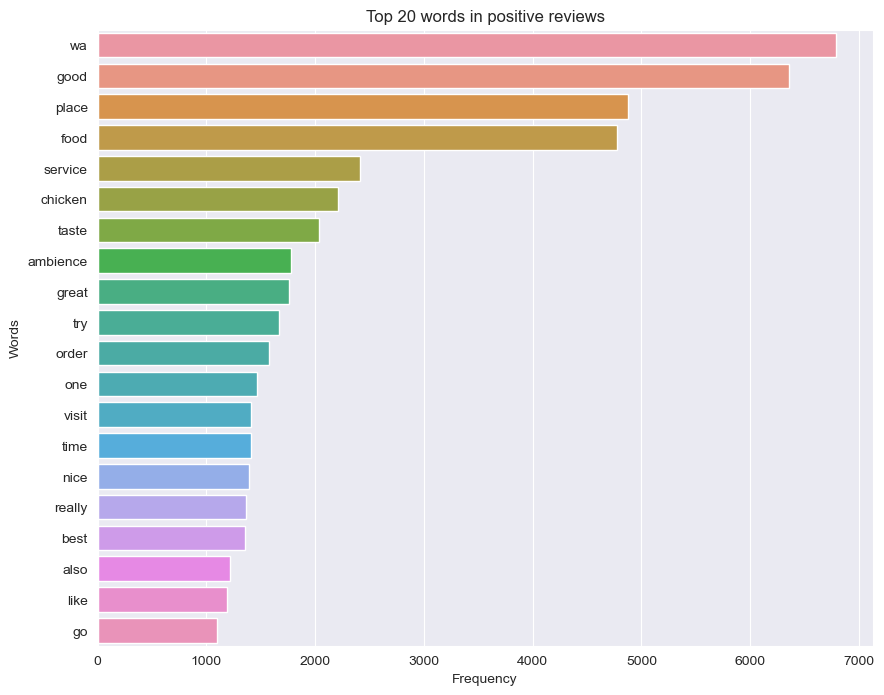

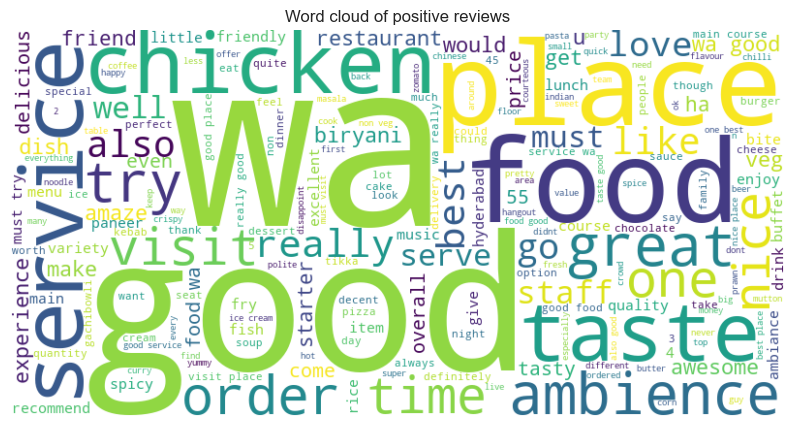

In [93]:
# Positive reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 0)
plot_term_frequency(word_freq_df, 20, 'positive')
plot_wordcloud(word_freq_df, 'positive')

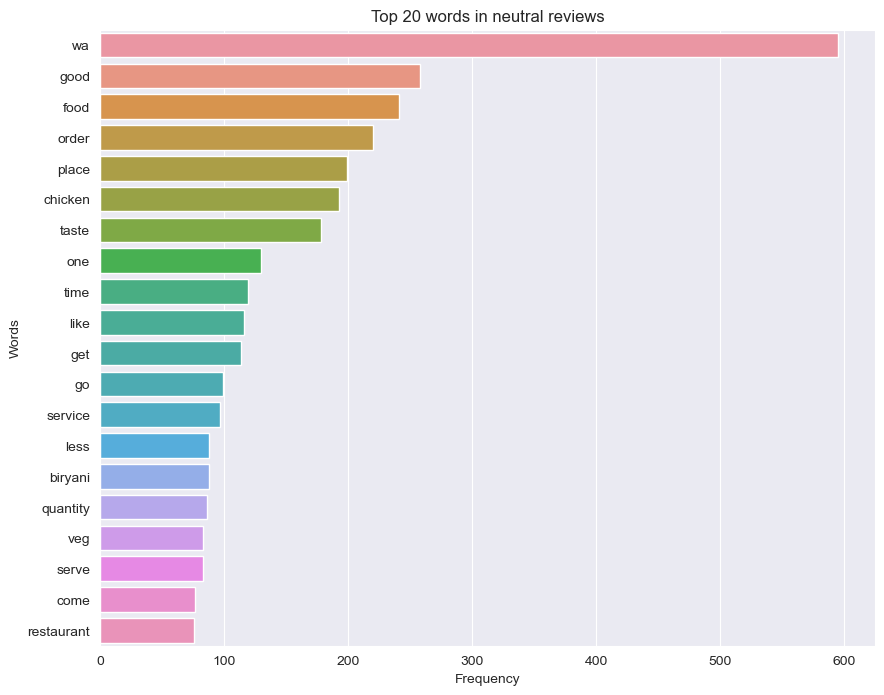

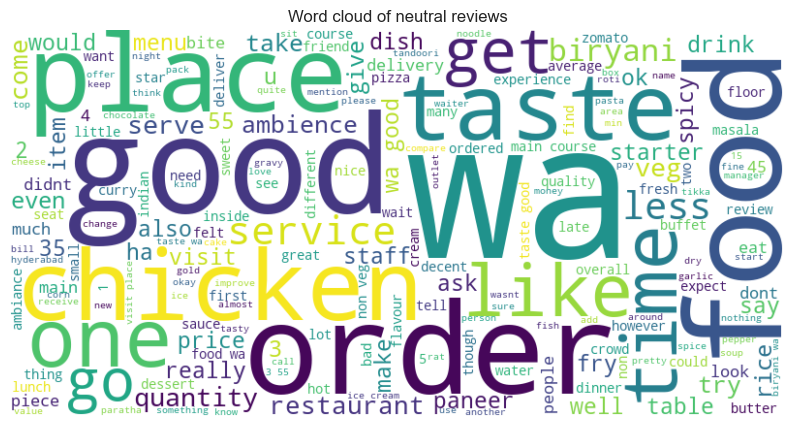

In [94]:
# Neutral reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 1)
plot_term_frequency(word_freq_df, 20, 'neutral')
plot_wordcloud(word_freq_df, 'neutral')

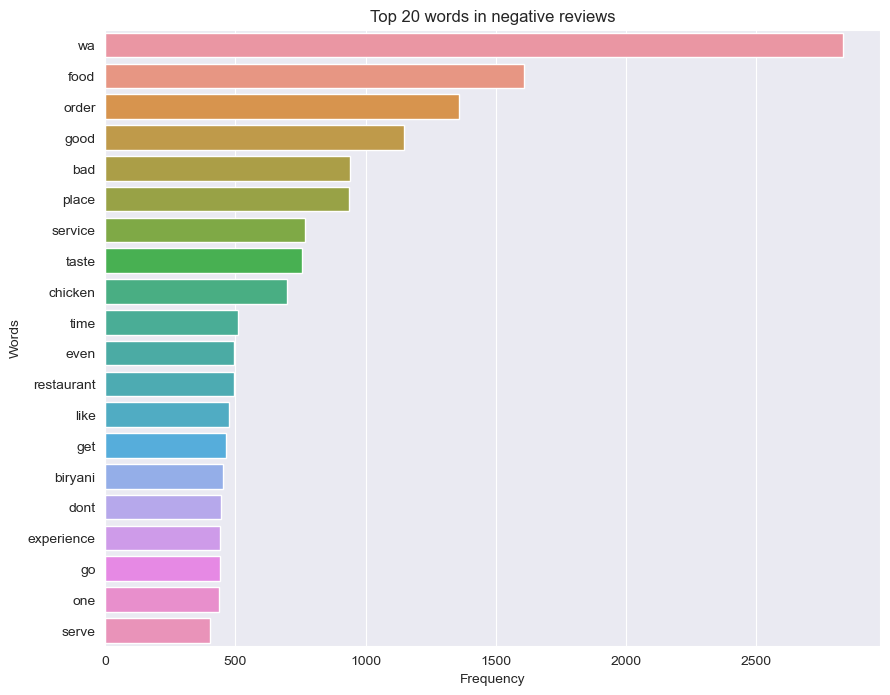

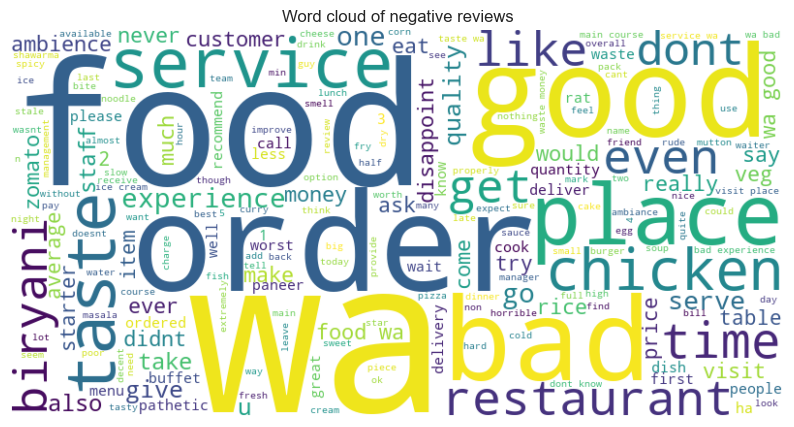

In [95]:
# Negative reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 2)
plot_term_frequency(word_freq_df, 20, 'negative')
plot_wordcloud(word_freq_df, 'negative')

SENTIMENT ANALYSIS WITH PROBABILITIES

In [96]:
reviews_sentiment_polariy = reviews_preproc.copy()

In [97]:
def optimus_sentimenter(review):
    encoded_input = sentiment_tokenizer(review, return_tensors='pt', truncation=True, max_length=510)
    sent = sentiment_model(**encoded_input)
    sent_scores = softmax(sent[0][0].detach().numpy())
    sent_scores_dict = {
    'negative': sent_scores[0],
    'neutral': sent_scores[1],
    'positive': sent_scores[2]}
    return sent_scores_dict

In [98]:
negative_scores = []
neutral_scores = []
positive_scores = []

for review in reviews_sentiment_polariy['Preprocessed_Review']:
    try:
        scores = optimus_sentimenter(review)
        negative_scores.append(scores['negative'])
        neutral_scores.append(scores['neutral'])
        positive_scores.append(scores['positive'])
    except RuntimeError as e:
        print(f"RuntimeError for review: {review}\nError: {e}")
        negative_scores.append(None)
        neutral_scores.append(None)
        positive_scores.append(None)

reviews_sentiment_polariy['negative'] = negative_scores
reviews_sentiment_polariy['neutral'] = neutral_scores
reviews_sentiment_polariy['positive'] = positive_scores

KeyboardInterrupt: 

In [99]:
#This model outputs 3 labels and their scores: negative, netural and positive. We then calculate polarity score.
#Polarity score = (negatives - positives) / (negatives + positives)
reviews_sentiment_polariy = pd.read_csv('reviews_sentiment_polarity.csv')

In [100]:
reviews_sentiment_polariy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   negative             9954 non-null   float64
 9   neutral              9954 non-null   float64
 10  positive             9954 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 855.5+ KB


In [101]:
reviews_sentiment_polariy['Polarity'] = (reviews_sentiment_polariy['positive'] - reviews_sentiment_polariy['negative'])/ \
(reviews_sentiment_polariy['positive'] + reviews_sentiment_polariy['negative'])

In [102]:
reviews_sentiment_polariy['Rating_Scaled'] = ((reviews_sentiment_polariy['Rating'].astype(float) - 1) / 2) - 1

In [103]:
corr_spearman = reviews_sentiment_polariy[['Rating_Scaled', 'Polarity']].corr(method='spearman')
corr_pearson = reviews_sentiment_polariy[['Rating_Scaled', 'Polarity']].corr(method='pearson')

print(f"Spearman correlation: {round(corr_spearman.iloc[0][1],2)}")
print(f"Pearson correlation: {round(corr_pearson.iloc[0][1],2)}")

Spearman correlation: 0.73
Pearson correlation: 0.84


In [104]:
reviews_sentiment_polariy.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,negative,neutral,positive,Polarity,Rating_Scaled
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",0.004108,0.020891,0.975001,0.991608,1.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,0.005603,0.015750,0.978647,0.988615,1.0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,0.003418,0.008538,0.988044,0.993104,1.0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,0.006249,0.021480,0.972271,0.987228,1.0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,0.003587,0.015610,0.980803,0.992711,1.0


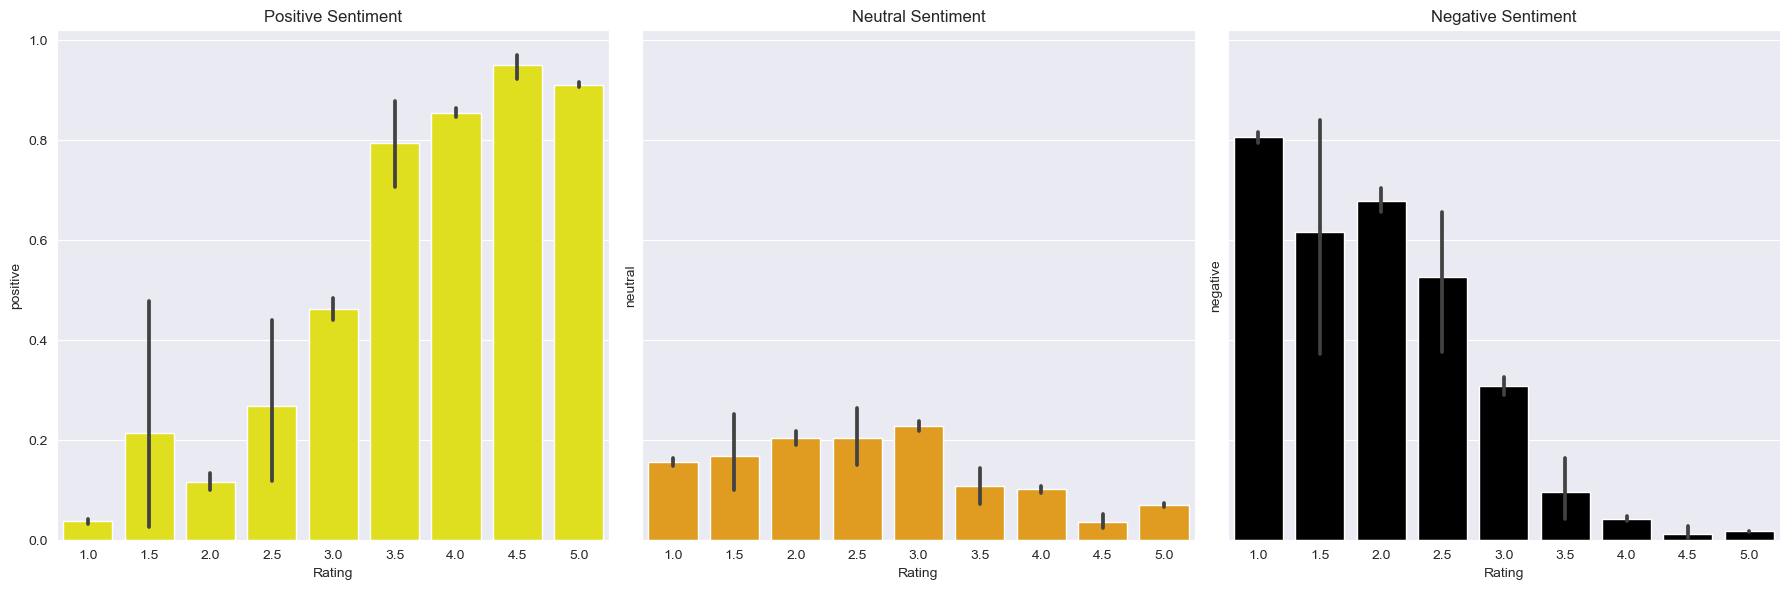

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='positive',color='yellow', ax=axes[0])
axes[0].set_title('Positive Sentiment')

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='neutral', color='orange', ax=axes[1])
axes[1].set_title('Neutral Sentiment')

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='negative', color='black', label='negative', ax=axes[2])
axes[2].set_title('Negative Sentiment')

plt.tight_layout()
plt.show()

In [106]:
# Reviews that were rated as negative (rating 1 , 1.5, 2) but model classified as positive
reviews_sent_pos = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] <2.5) & (reviews_sentiment_polariy['Polarity'] > 0.5)].sort_values(by='Polarity', ascending=False)
reviews_sent_pos.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1.0,40.0,0.843234,0.129840,0.503860,0.746833,0.878669,0.954903,0.988703
1.5,2.0,0.966347,0.018141,0.953519,0.959933,0.966347,0.972761,0.979175
2.0,72.0,0.839747,0.148170,0.507940,0.754081,0.908628,0.968074,0.990361


In [107]:
# Reviews that were rated as neutral (rating 2.5, 3 , 3.5) but model classified as negative
reviews_sent_nue = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=2.5) & (reviews_sentiment_polariy['Rating'] <4)
                                             & (reviews_sentiment_polariy['Polarity'] < -0.25)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_nue.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
2.5,12.0,-0.872876,0.124472,-0.977427,-0.965497,-0.940307,-0.744798,-0.635713
3.0,463.0,-0.825768,0.189478,-0.989099,-0.968213,-0.916485,-0.737101,-0.253424
3.5,4.0,-0.870590,0.125972,-0.979141,-0.964993,-0.897753,-0.803350,-0.707712


In [108]:
# Reviews that were rated as neutral (rating 2.5, 3 , 3.5) but model classified as positive
reviews_sent_nue2 = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=2.5) & (reviews_sentiment_polariy['Rating'] <4)
                                             & (reviews_sentiment_polariy['Polarity'] > 0.5)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_nue2.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
2.5,4.0,0.975864,0.013757,0.956067,0.971749,0.981006,0.985122,0.985376
3.0,602.0,0.910393,0.114116,0.500109,0.877738,0.962855,0.985038,0.996161
3.5,40.0,0.958159,0.098455,0.522065,0.972163,0.988669,0.992931,0.994876


In [109]:
#Reviews that were rated as positive (4, 4.5 or 5), but model classified as negatve
reviews_sent_neg = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=4) & \
                                             (reviews_sentiment_polariy['Polarity'] < -0.25)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_neg.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
4.0,107.0,-0.737218,0.204333,-0.987786,-0.918556,-0.803038,-0.580396,-0.262694
4.5,1.0,-0.796625,NaN,-0.796625,-0.796625,-0.796625,-0.796625,-0.796625
5.0,30.0,-0.712925,0.210267,-0.981282,-0.906770,-0.736401,-0.560483,-0.282108


**VADER**

In [125]:
reviews_sentiment_label = pd.read_csv('reviews_sentiment_label.csv')

In [126]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",positive,0.975001
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,positive,0.978647
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,positive,0.988044
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,positive,0.972271
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,positive,0.980803
...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,positive,0.870036
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,positive,0.983094
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",negative,0.531457
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,positive,0.982623


In [127]:
# labels into numbers - 'negative': 0, 'neutral': 1,'positive': 2
reviews_sentiment_label['Sentiment_Label'] = reviews_sentiment_label['Sentiment_Label'].map(
    {'negative': 0, 'neutral': 1, 'positive': 2})

In [128]:
# to distinguish between Vader sentiment analysis and transformer-based sentiment analysis
reviews_sentiment_label.rename(
    columns={"Sentiment_Label": "Transformer_Sentiment_Label", "Sentiment_Score": "Transformer_Sentiment_Score"},
    inplace=True)

In [129]:
vader = SentimentIntensityAnalyzer()

In [130]:
#example
print(reviews_sentiment_label['Preprocessed_Review'].iloc[0])
print(vader.polarity_scores(reviews_sentiment_label['Review'].iloc[0]))

The ambience was good, food was quite good. had Saturday lunch, which was cost effective. Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.
{'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'compound': 0.9664}


In [131]:
reviews_compound_list = []
for review in reviews_sentiment_label['Review']:
    review_polarity = vader.polarity_scores(review)
    reviews_compound_list.append(review_polarity["compound"])

In [132]:
reviews_sentiment_label["VADER_Sentiment_Score"] = reviews_compound_list

In [133]:
reviews_sentiment_label["VADER_Sentiment_Label"] = list(
    map(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral",
        reviews_sentiment_label["VADER_Sentiment_Score"]))

In [135]:
reviews_sentiment_label['VADER_Sentiment_Label'] = reviews_sentiment_label['VADER_Sentiment_Label'].map(
    {'negative': 0, 'neutral': 1, 'positive': 2})

In [136]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Transformer_Sentiment_Label,Transformer_Sentiment_Score,VADER_Sentiment_Score,VADER_Sentiment_Label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,0.9664,2
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,0.9360,2
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,0.9186,2
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,0.8591,2
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,0.9201,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,2,0.870036,0.9923,2
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,2,0.983094,0.9579,2
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0,0.531457,0.9785,2
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,2,0.982623,0.9359,2


In [137]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(
    lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [140]:
reviews_sentiment_label[["Rating_label", "Transformer_Sentiment_Label", "VADER_Sentiment_Label"]]

,Rating_label,Transformer_Sentiment_Label,VADER_Sentiment_Label
0,2,2,2
1,2,2,2
2,2,2,2
3,2,2,2
4,2,2,2
...,...,...,...
9949,1,2,2
9950,2,2,2
9951,0,0,2
9952,2,2,2


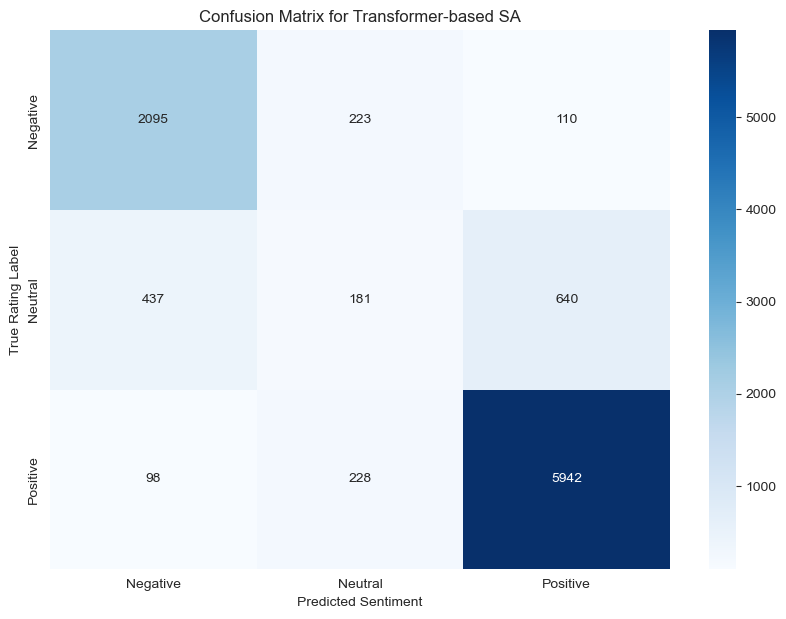

In [149]:
from sklearn.metrics import confusion_matrix

# confusion matrix TRANSFORMER
conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'],
                                reviews_sentiment_label['Transformer_Sentiment_Label'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for Transformer-based SA')
# plt.savefig("cf-transformer.jpg", format='jpg')
plt.show()

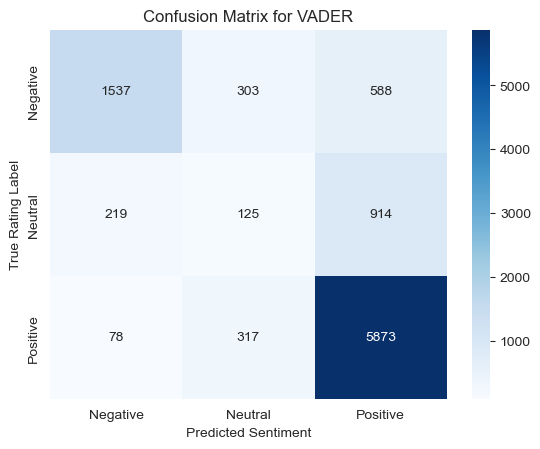

In [150]:
# confusion matrix VADER
conf_matrix2 = confusion_matrix(reviews_sentiment_label['Rating_label'],
                                reviews_sentiment_label['VADER_Sentiment_Label'])
# conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'],
#                                 reviews_sentiment_label['Transformer_Sentiment_Label'])

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for VADER')
# plt.savefig("cf-vader.jpg", format='jpg')
plt.show()


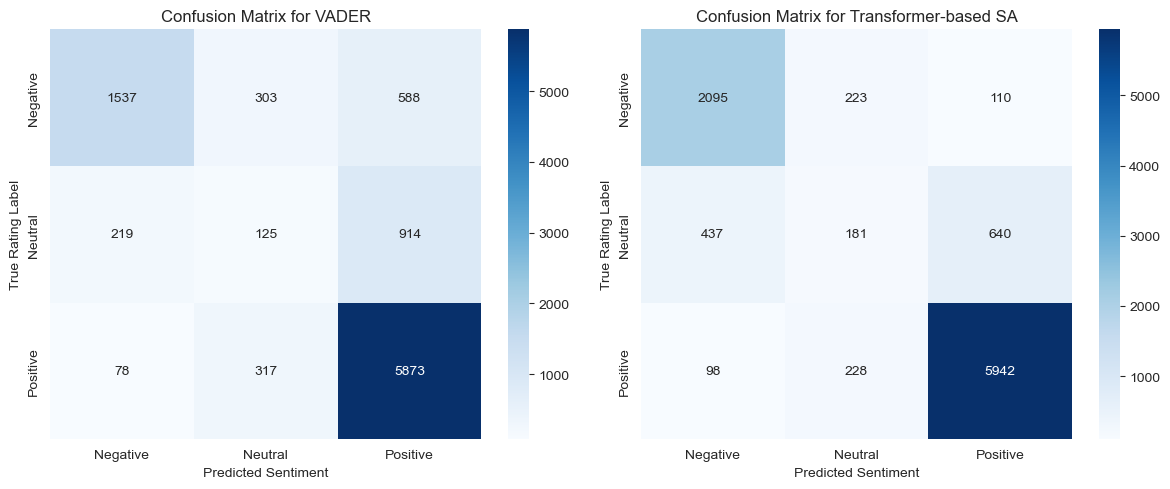

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for side-by-side comparison

# VADER Confusion Matrix
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('True Rating Label')
axes[0].set_title('Confusion Matrix for VADER')

# Transformer-based Confusion Matrix
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('True Rating Label')
axes[1].set_title('Confusion Matrix for Transformer-based SA')

# Adjust layout for readability
plt.tight_layout()
plt.savefig("cf-for-both.jpg")
plt.show()

In [152]:
accuracy_trans = round((conf_matrix1.trace()) / conf_matrix1.sum(), 2)
accuracy_vader = round((conf_matrix2.trace()) / conf_matrix2.sum(), 2)
print("accuracy for transformer:", accuracy_trans)
print("accuracy for vader:", accuracy_vader)

accuracy for transformer: 0.83
accuracy for vader: 0.76


In [153]:
from sklearn.metrics import classification_report

true_labels = reviews_sentiment_label['Rating_label']
predicted_labels_VADER = reviews_sentiment_label['VADER_Sentiment_Label']
predicted_labels_Transf = reviews_sentiment_label['Transformer_Sentiment_Label']

# report converted into dict to save it as csv
report_VADER = classification_report(true_labels, predicted_labels_VADER,
                                     target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

report_Transf = classification_report(true_labels, predicted_labels_Transf,
                                      target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# DataFrame
df_VADER = pd.DataFrame(report_VADER).transpose()
df_Transf = pd.DataFrame(report_Transf).transpose()

# saving to CSV
df_VADER.to_csv("classification_report_VADER.csv", index=True)
df_Transf.to_csv("classification_report_Transformer.csv", index=True)

In [154]:
df_VADER

,precision,recall,f1-score,support
Negative,0.838059,0.633031,0.721258,2428.000000
Neutral,0.167785,0.099364,0.124813,1258.000000
Positive,0.796339,0.936981,0.860954,6268.000000
accuracy,0.756982,0.756982,0.756982,0.756982
macro avg,0.600728,0.556459,0.569008,9954.000000
weighted avg,0.727078,0.756982,0.733845,9954.000000


In [155]:
# Normalized_rating = (rating - 3)/2
df_for_corr = reviews_sentiment_label[reviews_sentiment_label['Rating'] != 'Like']
df_for_corr['Normalized_rating'] = (df_for_corr['Rating'].astype(float) - 3) / 2

In [156]:
df_for_corr[["Review", "Normalized_rating", "VADER_Sentiment_Score"]]

,Review,Normalized_rating,VADER_Sentiment_Score
0,"The ambience was good, food was quite good . h...",1.00,0.9664
1,Ambience is too good for a pleasant evening. S...,1.00,0.9360
2,A must try.. great food great ambience. Thnx f...,1.00,0.9186
3,Soumen das and Arun was a great guy. Only beca...,1.00,0.8591
4,Food is good.we ordered Kodi drumsticks and ba...,1.00,0.9201
...,...,...,...
9949,Madhumathi Mahajan Well to start with nice cou...,0.00,0.9923
9950,This place has never disappointed us.. The foo...,0.75,0.9579
9951,"Bad rating is mainly because of ""Chicken Bone ...",-0.75,0.9785
9952,I personally love and prefer Chinese Food. Had...,0.50,0.9359


In [157]:
# Correlation between VADER sentiment score and rating 
corr_spearman = df_for_corr[['Normalized_rating', 'VADER_Sentiment_Score']].corr(method='spearman')
corr_pearson = df_for_corr[['Normalized_rating', 'VADER_Sentiment_Score']].corr(method='pearson')

print(f"Spearman correlation: {round(corr_spearman.iloc[0][1], 2)}")
print(f"Pearson correlation: {round(corr_pearson.iloc[0][1], 2)}")

Spearman correlation: 0.57
Pearson correlation: 0.7


In [158]:
df_for_corr["Normalized_rating"] = pd.to_numeric(df_for_corr["Normalized_rating"], errors="coerce")
df_for_corr["VADER_Sentiment_Score"] = pd.to_numeric(df_for_corr["VADER_Sentiment_Score"], errors="coerce")

In [159]:
#MSE 
df_for_corr["MSE"] = (df_for_corr["Normalized_rating"] - df_for_corr["VADER_Sentiment_Score"]) ** 2
df_corr_sorted = df_for_corr.sort_values(by="MSE", ascending=False, )
df_corr_sorted[["Review", "Rating", 'VADER_Sentiment_Score', "MSE"]]

for _, row in df_corr_sorted.head(20).iterrows(): 
    print(f"Review: {row['Review']}")
    print(f"Rating: {row['Rating']}")
    print(f"Compound Score: {row['VADER_Sentiment_Score']}")
    print(f"MSE: {row['MSE']}")
    print("-" * 50)

Review: Fisherman's wharf used to be our fav joint when we lived in Goa. Excellent food and bevs.
Then we moved to Hyderabad, FMW followed.
We were so happy, to have a Goan restaurant just 5 min drive from home.
In the beginning it was great place to dine. Then it started getting local. Fishes started getting stale, fewer varieties ..Not so great.
Now , after about 3 years, it's more a typical curry point.
We ordered Mutton Xacuti and Kingfish Richado.
Fish was so firm and overcooked, richado overloaded with sweetness.
Mutton was out of the world, with heaps of Curry leaves(Kadi patta/Karia paku) , super high on heat....Reminded me of a Rayala curry in Dindi (Godavari distt ). Meat was cooked with extra affection that it took me 5 min to chew it like a bubblegum. I really thank myself for not ordering more.
Fisherman's wharf- such a disappointment.
Rating: 1.0
Compound Score: 0.9863
MSE: 3.94538769
--------------------------------------------------
Review: Zomato has asked me to be pol

In [160]:
df_corr_sorted[["Review", "Rating", "VADER_Sentiment_Score", "MSE"]]

,Review,Rating,VADER_Sentiment_Score,MSE
585,Fisherman's wharf used to be our fav joint whe...,1.0,0.9863,3.945388
7425,Zomato has asked me to be polite.. ok.. Faasos...,1.0,0.9816,3.926739
6140,It really been long time I have visited this p...,1.0,0.9737,3.895492
4514,"Place located just opposite of DLF gate no 3, ...",1.0,0.9671,3.869482
3701,A complete and absolute disaster. The place wh...,1.0,0.9598,3.840816
...,...,...,...,...
6382,very spicy,3.0,0.0000,0.000000
7579,food was not cooked....half fried chicken lolipop,3.0,0.0000,0.000000
6425,Decent place near DLF! Their fry piece chicken...,3.0,0.0000,0.000000
7540,average,3.0,0.0000,0.000000


In [161]:
# The highest MSE score
df_corr_sorted[
    ["Review", "Rating", "VADER_Sentiment_Score", "MSE", "Transformer_Sentiment_Score", "Transformer_Sentiment_Label",
     "VADER_Sentiment_Label"]].loc[585]

Review                         Fisherman's wharf used to be our fav joint whe...
Rating                                                                       1.0
VADER_Sentiment_Score                                                     0.9863
MSE                                                                     3.945388
Transformer_Sentiment_Score                                             0.869458
Transformer_Sentiment_Label                                                    2
VADER_Sentiment_Label                                                          2
Name: 585, dtype: object

EMOTION DETECTION

In [166]:
model_emotion = f"cardiffnlp/twitter-roberta-base-emotion"
emotion_model = AutoModelForSequenceClassification.from_pretrained(model_emotion)
emotion_tokenizer = AutoTokenizer.from_pretrained(model_emotion)
#optimus_primer = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

pytorch_model.bin:  50%|#####     | 252M/499M [00:00<?, ?B/s]

C:\Users\karom\miniconda3\envs\text-mining1\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karom\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [167]:
# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
labels

['anger', 'joy', 'optimism', 'sadness']

In [168]:
reviews_emotions = reviews_preproc.copy()

In [169]:
# Initialize lists to store scores for each emotion
joy_scores = []
optimism_scores = []
anger_scores = []
sadness_scores = []

for review in tqdm(reviews_emotions['Preprocessed_Review']):
    encoded_input = emotion_tokenizer(review, return_tensors='pt', truncation=True, max_length=510)
    output = emotion_model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    
    # Append scores to respective lists
    joy_scores.append(scores[labels.index('joy')])
    optimism_scores.append(scores[labels.index('optimism')])
    anger_scores.append(scores[labels.index('anger')])
    sadness_scores.append(scores[labels.index('sadness')])

# Create new columns in the DataFrame
reviews_emotions['joy'] = joy_scores
reviews_emotions['optimism'] = optimism_scores
reviews_emotions['anger'] = anger_scores
reviews_emotions['sadness'] = sadness_scores


  0%|          | 1/9954 [00:09<25:55:48,  9.38s/it]


KeyboardInterrupt: 

In [170]:
reviews_emotions = pd.read_csv('reviews_emotions.csv')

In [171]:
reviews_emotions.loc[585]

Restaurant                                         The Fisherman's Wharf
Reviewer                                                         Shishir
Review                 Fisherman's wharf used to be our fav joint whe...
Rating                                                               1.0
Metadata                                                        1 Review
Time                                                     3/19/2019 22:30
Pictures                                                               0
Preprocessed_Review    Fisherman is wharf used to be our fav joint wh...
joy                                                             0.380793
optimism                                                        0.048829
anger                                                           0.342795
sadness                                                         0.227584
Name: 585, dtype: object

In [172]:
reviews_emotions=reviews_emotions[['Rating', 'Preprocessed_Review', 'joy', 'optimism', 'anger', 'sadness']]

In [173]:
reviews_emotions_neg = reviews_emotions[(reviews_emotions['Rating'] < 2.5)]
mean_emotions_neg = reviews_emotions_neg.groupby('Rating').mean().reset_index()
mean_emotions_neg

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\462613864.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_emotions_neg = reviews_emotions_neg.groupby('Rating').mean().reset_index()


,Rating,joy,optimism,anger,sadness
0,1.0,0.036229,0.016372,0.804027,0.143371
1,1.5,0.073985,0.019328,0.766965,0.139722
2,2.0,0.103319,0.030055,0.658492,0.208134


C:\Users\karom\AppData\Local\Temp\ipykernel_19752\2610626131.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_emotions = reviews_emotions.groupby('Rating').mean().reset_index()


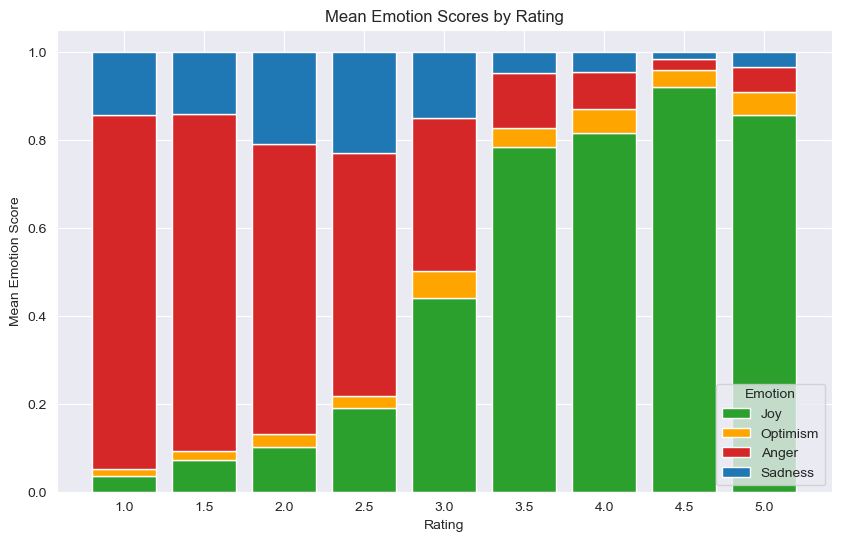

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Reviews that were rated as negative
mean_emotions = reviews_emotions.groupby('Rating').mean().reset_index()

# Extract data
ratings = mean_emotions['Rating']
joy = mean_emotions['joy']
optimism = mean_emotions['optimism']
anger = mean_emotions['anger']
sadness = mean_emotions['sadness']

# Bar positions
x = np.arange(len(ratings))

# Plot stacked bars with new color palette
plt.figure(figsize=(10, 6))
plt.bar(x, joy, label='Joy', color='#2ca02c')
plt.bar(x, optimism, bottom=joy, label='Optimism', color='#ffa500')
plt.bar(x, anger, bottom=joy + optimism, label='Anger', color='#d62728')
plt.bar(x, sadness, bottom=joy + optimism + anger, label='Sadness', color='#1f77b4')

# Add labels, legend, and title
plt.xticks(x, ratings)
plt.xlabel('Rating')
plt.ylabel('Mean Emotion Score')
plt.title('Mean Emotion Scores by Rating')
plt.legend(title='Emotion')

plt.savefig("emotions.jpg")
# Show plot
plt.show()

In [175]:
# Reviews that were rated as neutral
reviews_emotions_neu = reviews_emotions[(reviews_emotions['Rating'] >2) & (reviews_emotions['Rating'] <4)]
reviews_emotions_neu.groupby('Rating').mean()

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\138651559.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews_emotions_neu.groupby('Rating').mean()


,joy,optimism,anger,sadness
Rating,,,,
2.5,0.191433,0.027169,0.552293,0.229105
3.0,0.441682,0.061010,0.347203,0.150105
3.5,0.783951,0.043434,0.125244,0.047370


In [176]:
# Reviews that were rated as positive
reviews_emotions_pos = reviews_emotions[(reviews_emotions['Rating']>3.5)]
reviews_emotions_pos.groupby('Rating').mean()

C:\Users\karom\AppData\Local\Temp\ipykernel_19752\3480122036.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews_emotions_pos.groupby('Rating').mean()


,joy,optimism,anger,sadness
Rating,,,,
4.0,0.816333,0.054272,0.083645,0.045749
4.5,0.921670,0.037501,0.025861,0.014968
5.0,0.858456,0.052262,0.056971,0.032311
